The code for model training is based on the programming assignments from Coursera's "Generative Adversarial Networks (GANs) Specialization" by Sharon Zhou et al.

(https://www.coursera.org/specializations/generative-adversarial-networks-gans)

In [1]:
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from gans import utils
from gans.datasets import PokemonDataset
from gans.models import dcgan

In [2]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 100
z_dim = 64
display_step = 10
batch_size = 32
lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999

In [3]:
dataset = PokemonDataset(set="basic")
dataloader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
device = "cpu"

gen = dcgan.Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = dcgan.Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

 29%|███████████████████████████▉                                                                   | 10/34 [06:37<16:25, 41.07s/it]

Step 10: Generator loss: 0.8323168218135834, Discriminator loss: 0.7858856439590454


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


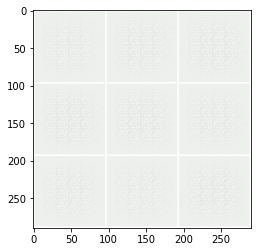

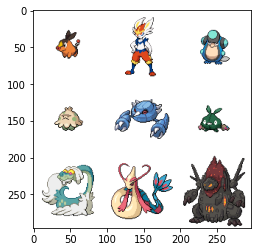

 59%|███████████████████████████████████████████████████████▉                                       | 20/34 [13:06<08:46, 37.58s/it]

Step 20: Generator loss: 0.7832189500331879, Discriminator loss: 0.7032209992408751


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


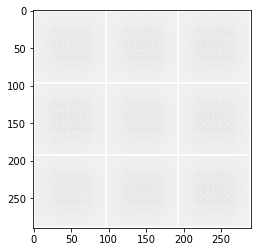

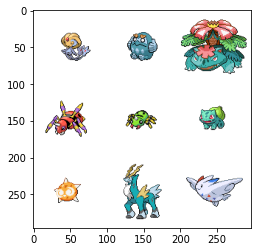

 88%|███████████████████████████████████████████████████████████████████████████████████▊           | 30/34 [19:48<02:39, 39.91s/it]

Step 30: Generator loss: 0.7684933602809906, Discriminator loss: 0.6978597879409791


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


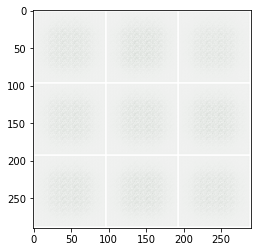

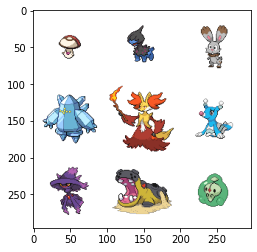

 18%|████████████████▉                                                                               | 6/34 [04:03<19:10, 41.09s/it]

Step 40: Generator loss: 0.8036415755748748, Discriminator loss: 0.6757115125656128


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


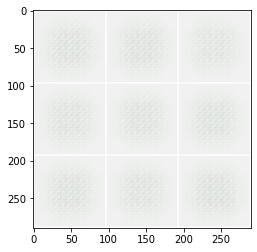

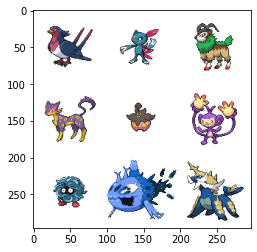

 29%|███████████████████████████▉                                                                   | 10/34 [06:50<16:25, 41.08s/it]


KeyboardInterrupt: 

In [4]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    for real in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        disc_opt.zero_grad()
        disc_loss = dcgan.get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        gen_opt.zero_grad()
        gen_loss = dcgan.get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step > 0:
            print(
                f"Step {cur_step}: Generator loss: {mean_generator_loss}, "
                f"Discriminator loss: {mean_discriminator_loss}"
            )
            fake_noise = utils.get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            utils.show_tensor_images(fake, size=(4, 94, 94))
            utils.show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
